<a href="https://colab.research.google.com/github/paupuleti/ML-project-on-Bitcoin-price-prediction1/blob/main/MiniFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

maindf=pd.read_csv('/content/BTC-USD (9).csv')
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])
maindf.shape
maindf.head()
maindf.tail()
maindf.info()
maindf.describe()
print('Null Values:',maindf.isnull().values.sum())
print('NA values:',maindf.isnull().values.any())
maindf.shape

Total number of days present in the dataset:  1096
Total number of fields present in the dataset:  7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1096 non-null   object 
 1   Open       1096 non-null   float64
 2   High       1096 non-null   float64
 3   Low        1096 non-null   float64
 4   Close      1096 non-null   float64
 5   Adj Close  1096 non-null   float64
 6   Volume     1096 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.1+ KB
Null Values: 0
NA values: False


(1096, 7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Printing the start date and End date of the dataset
sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]
print('Starting Date',sd)
print('Ending Date',ed)
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')
y_overall = maindf.loc[(maindf['Date'] >= '2020-03-05')
                     & (maindf['Date'] <= '2023-03-05')]
y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)
monthvise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise
names = cycle(['Open Price','Close Price','High Price','Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'],
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Price value'})
fig.update_layout(title_text='Attributes Price analysis chart', font_size=15, font_color='black',legend_title_text='Close Price Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Starting Date 2020-03-05
Ending Date 2023-03-05


In [ ]:
# Lets First Take all the Close Price
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Price'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Bitcoin Close price 2020-2023', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
closedf = closedf[closedf['Date'] > '2020-03-05']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])


Shape of close dataframe: (1096, 2)


Total data for prediction:  1095


In [ ]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
(365, 1)
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
print(test_size)

(1095, 1)
train_data:  (876, 1)
test_data:  (219, 1)
219


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)
# reshape input to be [samples, time steps, features which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (860, 15)
y_train:  (860,)
X_test:  (203, 15)
y_test (203,)
X_train:  (860, 15, 1)
X_test:  (203, 15, 1)


Epoch 1/200
27/27 [==============================] - 2s 17ms/step - loss: 0.0277 - val_loss: 3.6662e-04
Epoch 2/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 4.2721e-04
Epoch 3/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 2.9528e-04
Epoch 4/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 2.6981e-04
Epoch 5/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 2.8542e-04
Epoch 6/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 3.5350e-04
Epoch 7/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 4.0120e-04
Epoch 8/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 3.8656e-04
Epoch 9/200
27/27 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 4.0258e-04
Epoch 10/200
27/27 [==============================] - 0s 8ms/step - loss

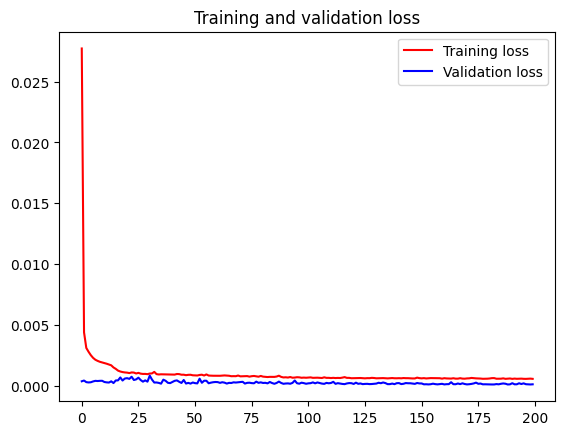

<Figure size 640x480 with 0 Axes>

In [ ]:
model=Sequential()
model.add(LSTM(10,input_shape=(None,1),activation="relu"))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
### Lets Do the prediction and check performance metrics
from sklearn.metrics import mean_absolute_percentage_error
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

print("Test data MAPE: ", mean_absolute_percentage_error(original_ytest, test_predict))

7/7 [==============================] - 0s 3ms/step
Test data RMSE:  676.0025609292067
Test data MSE:  456979.4623828457
Test data explained variance regression score: 0.9356250490375356
Test data R2 score: 0.9261435845775933
Test data MAPE:  0.02373924397732452


In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Test predicted data:  (1095, 1)


In [ ]:

# Predicting next 30 days
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
from numpy import array
lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)


Output of predicted next days:  30
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()